# Merged model evaluation

In [1]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np




/Users/callithrix/Documents/Projects/Functional_Fusion/code/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/callithrix/code/Python/ProbabilisticParcellation/functional_profiles.py:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if info_type is 'model_info':
/Users/callithrix/code/Python/ProbabilisticParcellation/functional_profiles.py:70: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif info_type is 'evaluation_info':


In [2]:
files = sorted(
    glob.glob(f'{ut.model_dir}//Models/Evaluation/nettekoven_68/eval_*'))

list_of_dfs = []
for f, file in enumerate(files):
    t = pd.read_csv(file, delimiter='\t')
    list_of_dfs.append(t)
    t['source'] = file.split('/')[-1].strip('.tsv')

D = pd.concat(list_of_dfs, ignore_index=True).reset_index(drop=True)
D.drop_duplicates(subset=D.columns.difference(['source']))

D.shape

(6506, 15)

In [11]:
crits = ['dcbc_group','dcbc_indiv']

# recover info
for r,row in D.iterrows():
    new = fp.recover_info(row, info_type='evaluation_info')
    D.iloc[r] = new
                    

figsize = (10,10)
# Determine origin of model: clustered_in_C3 (and then refitted to C2), clustered (on C2 or C3 data, but not refitted to another space), data (pure data-driven model)
for r,row in D.iterrows():
    if row['atlas'] == 'MNISymC2':
        if 'fromC3' in row['source']:
            D.loc[r,'origin'] = 'clustered_in_C3'
        elif 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'
    elif row['atlas'] == 'MNISymC3':
        if 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'

# Determine whether model was trained on rest, task and rest, or task only
for r,row in D.iterrows():
    if ['HCP'] == row['train_data']:
        D.loc[r, 'trained_on'] = 'rest'
    elif 'HCP' in row['train_data']:
        D.loc[r, 'trained_on'] = 'task_and_rest'
    else:
        D.loc[r, 'trained_on'] = 'task'
        

# Determine whether model was tested on rest, task and rest, or task only
for r, row in D.iterrows():
    if 'HCP' == row['test_data']:
        D.loc[r, 'tested_on'] = 'rest'
    else:
        D.loc[r, 'tested_on'] = 'task'

# Leave-one-out / All / Individual indicator
for r, row in D.iterrows():
    n_train_datasets = len(row['train_data'])
    if n_train_datasets==1:
        D['train_type'] = 'indiv'
    elif n_train_datasets==6:
        D['train_type'] = 'loo'
    elif n_train_datasets==7:
        if 'HCP' in row['train_data']:
            D['train_type'] = 'loo'
        else:
            D['train_type'] = 'all'
    elif n_train_datasets==8:
        D['train_type'] = 'all'

# Symmetric / Asymmetric indicator
for r, row in D.iterrows():
    if 'sym' in row['source']:  
        D.loc[r, 'symmetry'] = 'symmetric'
    else:
        D.loc[r, 'symmetry'] = 'asymmetric'


# Cross-validation indicator
for r, row in D.iterrows():
    train_test_match = [data in row.test_data for data in row.train_data]
    if np.any(train_test_match):
        D.loc[r, 'cv'] = False
    else:
        D.loc[r, 'cv'] = True

D.tail()


,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv
6501,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,95,True,0.083549,0.142998,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True
6502,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,96,True,0.072170,0.081665,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True
6503,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,97,True,0.076484,0.128629,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True
6504,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,98,True,0.145713,0.256534,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True
6505,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,99,True,0.090234,0.195431,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True


### Comparing clustered, clustered in C3 and data-driven parcellations for K=32

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_45279/3182203188.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  D[(D.train_type == 'all') & (D.K == 32)].groupby(['atlas','origin']).mean()


K  train_loglik   subj_num  common_kappa  \
atlas    origin                                                         
MNISymC2 clustered        32.0  6.449879e+07  29.142180           1.0   
         clustered_in_C3  32.0  6.521779e+07  10.801802           1.0   
         data             32.0  6.532013e+07  10.801802           1.0   
MNISymC3 clustered        32.0  1.940202e+07  10.801802           1.0   
         data             32.0  1.055076e+08  19.739030           1.0   

                          dcbc_group  dcbc_indiv  indivtrain_val  
atlas    origin                                                   
MNISymC2 clustered          0.088675    0.156923             1.5  
         clustered_in_C3    0.106587    0.167769             1.5  
         data               0.101088    0.172838             1.5  
MNISymC3 clustered          0.093097    0.171512             1.5  
         data               0.101587    0.175062             1.5

<Figure size 1000x1000 with 0 Axes>

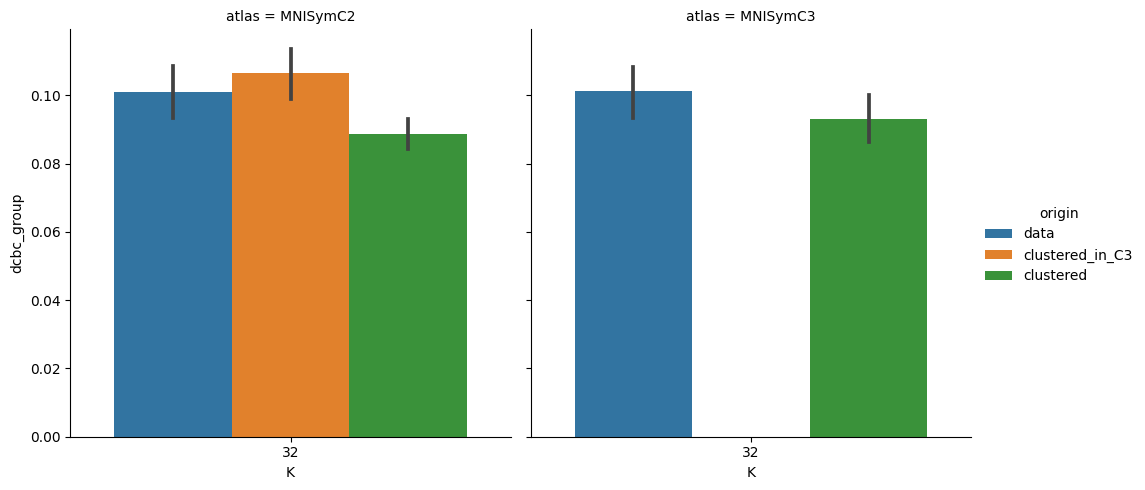

<Figure size 1000x1000 with 0 Axes>

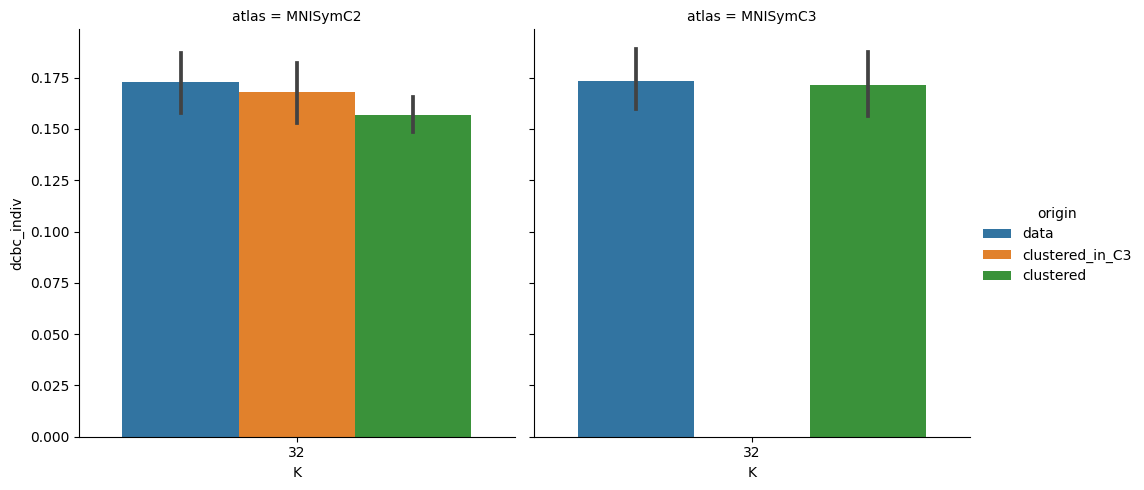

In [16]:

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.train_type == 'all') & (D.K == 32) & (D.trained_on == 'task')], x="K", y="dcbc_group", col="atlas", hue="origin", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.train_type == 'all') & (D.K == 32) & (D.trained_on == 'task')], x="K", y="dcbc_indiv", col="atlas", hue="origin", kind="bar")

# Get mean of DCBC for each origin
D[(D.train_type == 'all') & (D.K == 32)].groupby(['atlas','origin']).mean()
# D[(D.train_type == 'all') & (D.K == 32)].groupby(['atlas','origin']).std()

### Comparing pure task-trained, rest-and-task-trained, and rest-trained parcellations

<Figure size 1000x1000 with 0 Axes>

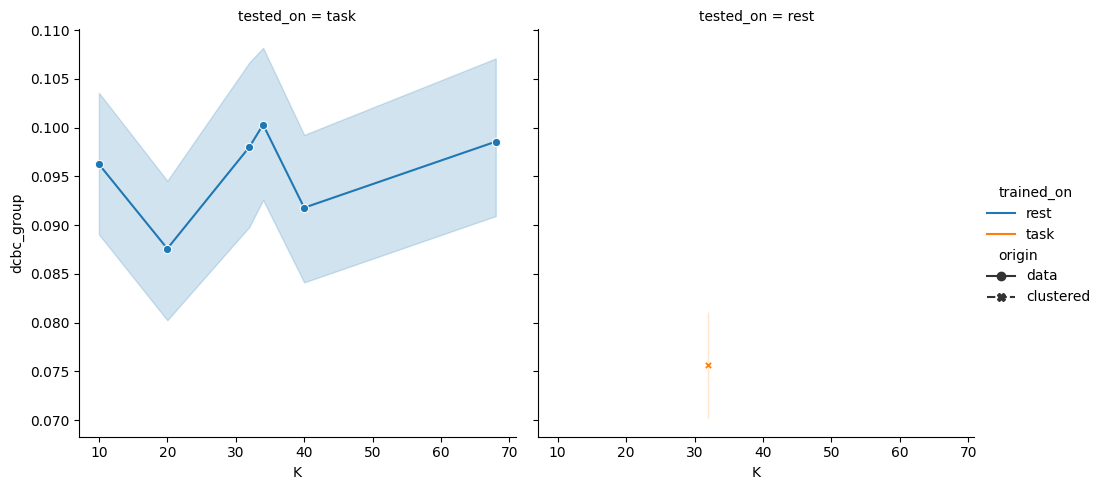

<Figure size 1000x1000 with 0 Axes>

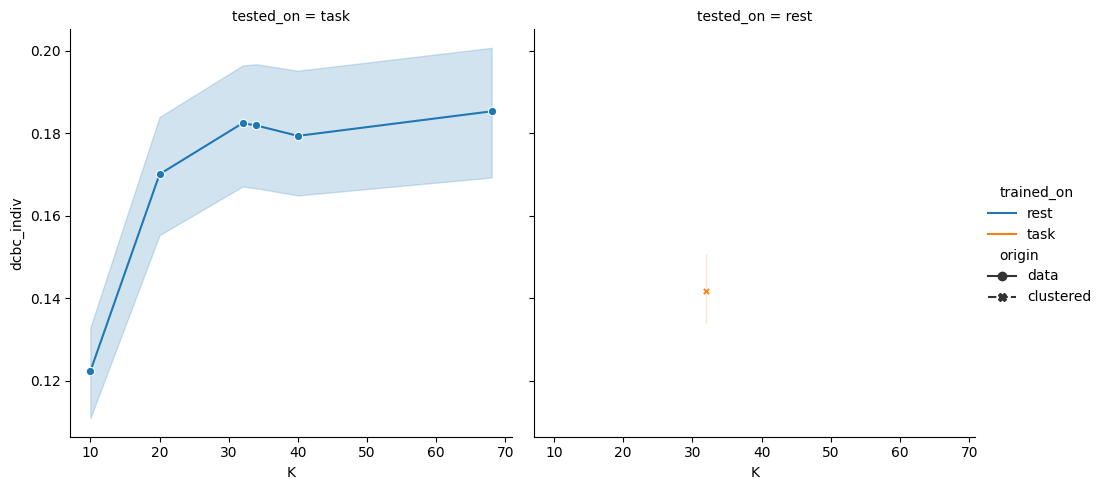

In [13]:

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv==True], x="K", y="dcbc_group", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_indiv", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)



In [14]:
D[(D.cv==True) & (D.tested_on=='task')].tail()

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv
2527,sym_Hc,MNISymC3,68,[HCP],130507368.0,3,True,0.136743,0.582562,Models_03,...,half,2,Somatotopic,eval_on-task_sym_Hc_space-MNISymC3_K-68,data,rest,task,all,symmetric,True
2528,sym_Hc,MNISymC3,68,[HCP],130507368.0,4,True,0.097242,0.571947,Models_03,...,half,2,Somatotopic,eval_on-task_sym_Hc_space-MNISymC3_K-68,data,rest,task,all,symmetric,True
2529,sym_Hc,MNISymC3,68,[HCP],130507368.0,5,True,0.224943,0.425022,Models_03,...,half,2,Somatotopic,eval_on-task_sym_Hc_space-MNISymC3_K-68,data,rest,task,all,symmetric,True
2530,sym_Hc,MNISymC3,68,[HCP],130507368.0,6,True,0.121875,0.435500,Models_03,...,half,2,Somatotopic,eval_on-task_sym_Hc_space-MNISymC3_K-68,data,rest,task,all,symmetric,True
2531,sym_Hc,MNISymC3,68,[HCP],130507368.0,7,True,-0.018998,0.246094,Models_03,...,half,2,Somatotopic,eval_on-task_sym_Hc_space-MNISymC3_K-68,data,rest,task,all,symmetric,True


<Figure size 1000x1000 with 0 Axes>

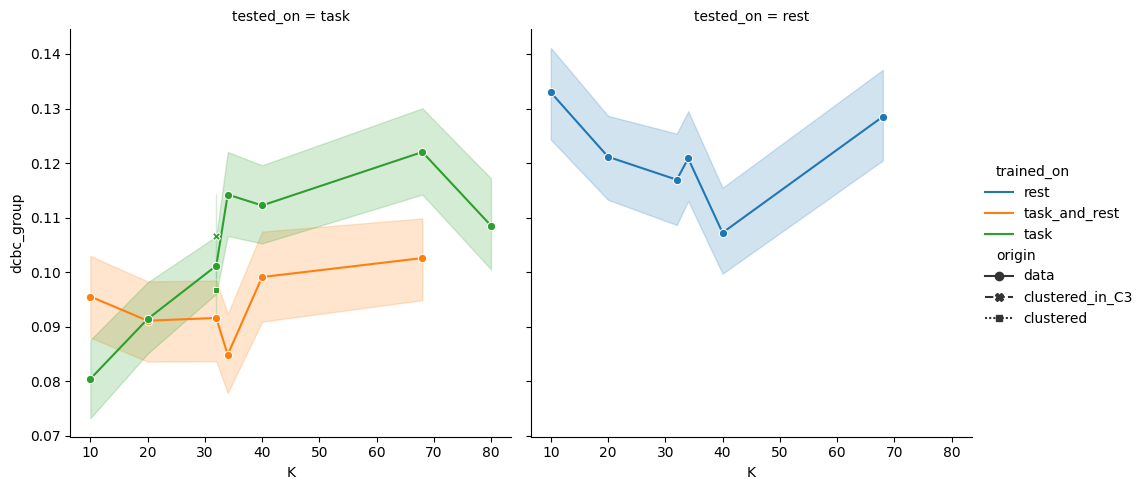

<Figure size 1000x1000 with 0 Axes>

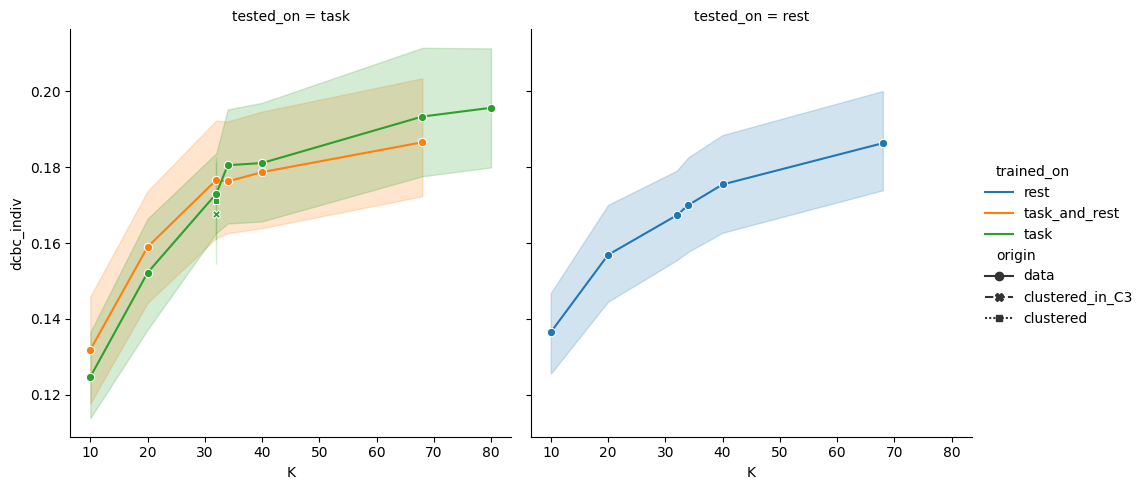

In [17]:

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == False], x="K", y="dcbc_group", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == False], x="K", y="dcbc_indiv", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)


<Figure size 1000x1000 with 0 Axes>

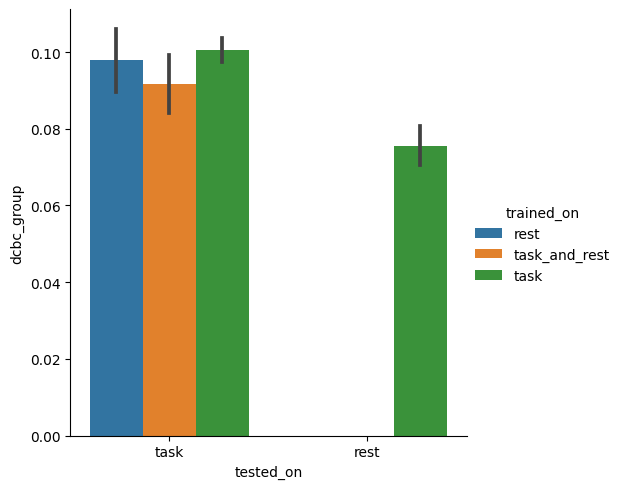

<Figure size 1000x1000 with 0 Axes>

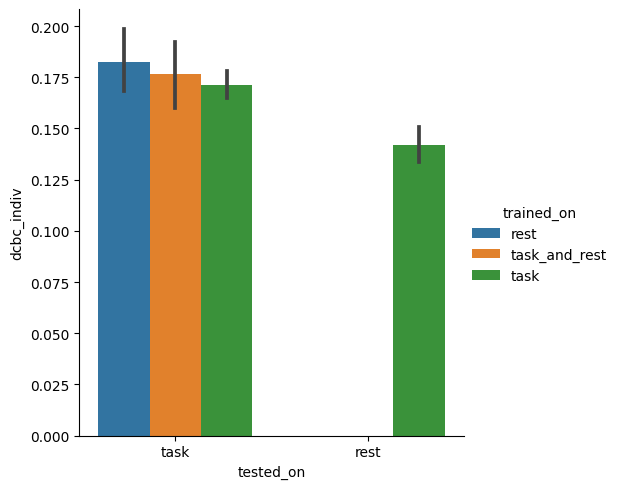

<Figure size 1000x1000 with 0 Axes>

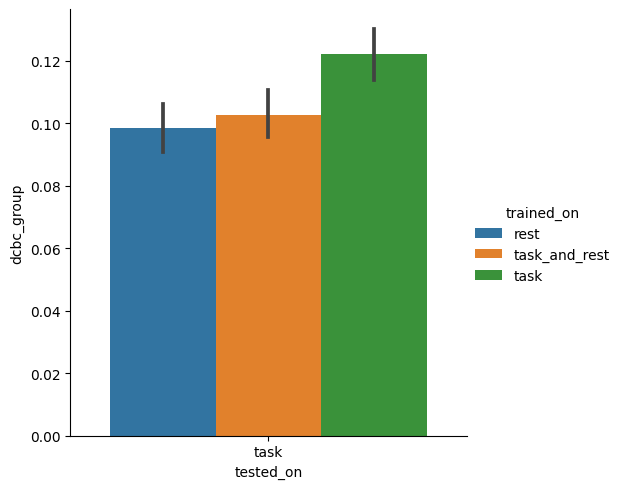

<Figure size 1000x1000 with 0 Axes>

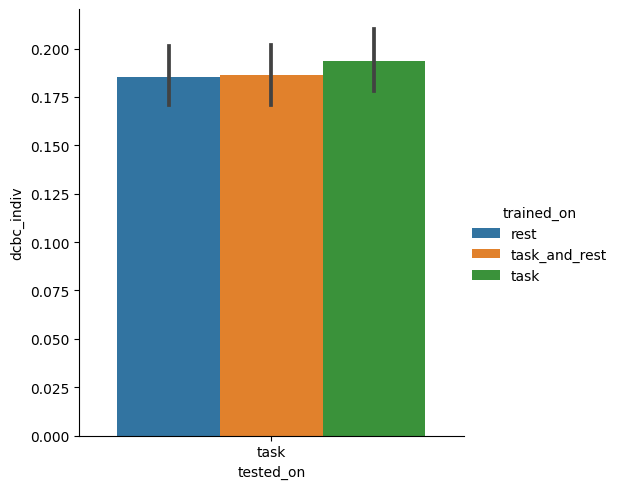

In [11]:

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 32)], x="tested_on", y="dcbc_group", hue="trained_on", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 32)], x="tested_on", y="dcbc_indiv", hue="trained_on", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 68)], x="tested_on", y="dcbc_group", hue="trained_on", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 68)], x="tested_on", y="dcbc_indiv", hue="trained_on", kind="bar")


### Comparing merged K 32 and data-derived K 34